In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

import tqdm
import joblib

import shap

pd.set_option('display.max_columns', 200)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
style.use('ggplot')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

# About Dataset

🧾**Description:** According to a report https://www.iea.org/reports/tracking-buildings-2021 issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. 

The dataset consists of building characteristics, weather data for the location of the building, as well as the energy usage for the building and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to a single building observed in a given year.

Source of DataSet : https://www.kaggle.com/c/widsdatathon2022/data

### Data Dictionary

#### Covariates

* id: building id

* Year_Factor: anonymized year in which the weather and energy usage factors were observed

* State_Factor: anonymized state in which the building is located

* building_class: building classification

* facility_type: building usage type

* floor_area: floor area (in square feet) of the building

* year_built: year in which the building was constructed

* energy_star_rating: the energy star rating of the building

* ELEVATION: elevation of the building location

* january_min_temp: minimum temperature in January (in Fahrenheit) at the location of the building

* january_avg_temp: average temperature in January (in Fahrenheit) at the location of the building

* january_max_temp: maximum temperature in January (in Fahrenheit) at the location of the building

* cooling_degree_days: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

* heating_degree_days: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

* precipitation_inches: annual precipitation in inches at the location of the building

* snowfall_inches: annual snowfall in inches at the location of the building

* snowdepth_inches: annual snow depth in inches at the location of the building

* avg_temp: average temperature over a year at the location of the building

* days_below_30F: total number of days below 30 degrees Fahrenheit at the location of the building

* days_below_20F: total number of days below 20 degrees Fahrenheit at the location of the building

* days_below_10F: total number of days below 10 degrees Fahrenheit at the location of the building

* days_below_0F: total number of days below 0 degrees Fahrenheit at the location of the building

* days_above_80F: total number of days above 80 degrees Fahrenheit at the location of the building

* days_above_90F: total number of days above 90 degrees Fahrenheit at the location of the building

* days_above_100F: total number of days above 100 degrees Fahrenheit at the location of the building

* days_above_110F: total number of days above 110 degrees Fahrenheit at the location of the building

* direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

* direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

* max_wind_speed: maximum wind speed at the location of the building

* days_with_fog: number of days with fog at the location of the building

#### Target

* site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

### High Level Inference

Since the target column contains continuous variables this problem is a regression problem.

Evaluation metric that will be used for this problem will be RMSE

# Step 1 : Load Data into dataset

In [2]:
train = pd.read_csv('SEI_train_dataset.csv')
test = pd.read_csv('SEI_x_test.csv')

In [93]:
df_train = train.copy()
df_test = test.copy()

In [4]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


# Step 2 : Exploratory Data Analysis

In [5]:
df_train.sample(5)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
36306,4,State_6,Residential,Multifamily_Uncategorized,225968.0,1952.0,88.0,3.4,4,28.596774,58,9,31.625000,56,13,37.661290,66,31,52.333333,77,49,64.000000,86,55,72.450000,89,63,76.145161,91,61,74.516129,90,52,69.733333,92,42,59.629032,77,22,45.300000,69,24,40.516129,65,1128,4875,53.79,50.0,377,54.501370,66,24,7,0,75,4,0,0,1.0,1.0,1.0,56.0,93.570563,36306
44050,5,State_6,Residential,Multifamily_Uncategorized,72130.0,1937.0,81.0,15.2,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,NaN,NaN,NaN,NaN,57.641645,44050
70507,5,State_11,Commercial,Health_Care_Inpatient,374466.0,1920.0,97.0,18.3,28,45.419355,63,32,48.321429,62,29,50.725806,71,37,51.850000,78,41,59.080645,81,48,67.083333,90,55,70.919355,96,51,68.403226,89,44,60.433333,80,46,57.500000,74,27,44.466667,59,29,43.435484,58,430,3742,39.35,0.0,0,55.693151,8,0,0,0,40,2,0,0,NaN,NaN,NaN,NaN,210.662105,70507
44363,5,State_6,Residential,Multifamily_Uncategorized,109546.0,2011.0,49.0,3.4,8,29.854839,56,2,23.946429,43,12,38.096774,62,32,54.250000,80,48,68.516129,88,50,71.183333,90,64,78.790323,96,63,78.967742,95,56,74.450000,97,35,58.048387,78,32,52.783333,74,34,50.774194,72,1581,4460,40.97,49.1,463,56.835616,63,34,9,0,106,12,0,0,310.0,NaN,19.2,111.0,43.587105,44363
65105,6,State_6,Residential,Multifamily_Uncategorized,56000.0,1926.0,84.0,24.4,11,34.451613,59,-1,37.706897,61,26,48.870968,79,26,53.333333,82,43,62.790323,92,52,72.250000,88,63,78.677419,96,61,79.177419,96,54,71.800000,91,38,58.758065,85,34,49.766667,72,17,38.338710,60,1489,4252,42.17,36.0,101,57.215847,40,11,2,1,96,17,0,0,NaN,NaN,NaN,NaN,80.479508,65105


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [7]:
df_train.head().T

,0,1,2,3,4
Year_Factor,1,1,1,1,1
State_Factor,State_1,State_1,State_1,State_1,State_1
building_class,Commercial,Commercial,Commercial,Commercial,Commercial
facility_type,Grocery_store_or_food_market,Warehouse_Distribution_or_Shipping_center,Retail_Enclosed_mall,Education_Other_classroom,Warehouse_Nonrefrigerated
floor_area,61242.0,274000.0,280025.0,55325.0,66000.0
...,...,...,...,...,...
direction_peak_wind_speed,1.0,NaN,NaN,NaN,1.0
max_wind_speed,1.0,1.0,1.0,1.0,1.0
days_with_fog,NaN,12.0,12.0,12.0,NaN
site_eui,248.682615,26.50015,24.693619,48.406926,3.899395


In [8]:
df_train.Year_Factor.value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

In [9]:
df_test.Year_Factor.value_counts()

7    9705
Name: Year_Factor, dtype: int64

In [10]:
# Sort DataFrame in date order
df_train.sort_values(by=["Year_Factor"], inplace=True, ascending=True)
df_train.Year_Factor.head(20)

0        1
15356    1
15357    1
15358    1
15359    1
15360    1
15361    1
15362    1
15363    1
15364    1
15365    1
15366    1
15367    1
15368    1
15369    1
15370    1
15371    1
15372    1
15373    1
15374    1
Name: Year_Factor, dtype: int64

In [11]:
df_train.State_Factor.value_counts()

State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: State_Factor, dtype: int64

In [12]:
df_train.building_class.value_counts()

Residential    43558
Commercial     32199
Name: building_class, dtype: int64

In [13]:
df_train.facility_type.value_counts()

Multifamily_Uncategorized                    39455
Office_Uncategorized                         12512
Education_Other_classroom                     3860
Lodging_Hotel                                 2098
2to4_Unit_Building                            1893
Commercial_Other                              1744
5plus_Unit_Building                           1273
Warehouse_Nonrefrigerated                     1255
Retail_Uncategorized                          1130
Education_College_or_university               1056
Nursing_Home                                   772
Education_Uncategorized                        709
Mixed_Use_Commercial_and_Residential           672
Lodging_Dormitory_or_fraternity_sorority       669
Warehouse_Distribution_or_Shipping_center      604
Warehouse_Selfstorage                          577
Grocery_store_or_food_market                   448
Office_Medical_non_diagnostic                  447
Health_Care_Inpatient                          409
Religious_worship              

In [14]:
# These columns contain strings
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

State_Factor
building_class
facility_type


In [15]:
# This will turn all of the string values into category values
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        df_train[label] = content.astype("category").cat.as_ordered()

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Year_Factor                75757 non-null  int64   
 1   State_Factor               75757 non-null  category
 2   building_class             75757 non-null  category
 3   facility_type              75757 non-null  category
 4   floor_area                 75757 non-null  float64 
 5   year_built                 73920 non-null  float64 
 6   energy_star_rating         49048 non-null  float64 
 7   ELEVATION                  75757 non-null  float64 
 8   january_min_temp           75757 non-null  int64   
 9   january_avg_temp           75757 non-null  float64 
 10  january_max_temp           75757 non-null  int64   
 11  february_min_temp          75757 non-null  int64   
 12  february_avg_temp          75757 non-null  float64 
 13  february_max_temp          7575

In [17]:
df_train.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

## Fill missing values

From our experience with machine learning models. We know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_train.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### Filling numerical values first

We're going to fill any column with missing values with the median of that column.

In [18]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Year_Factor
floor_area
year_built
energy_star_rating
ELEVATION
january_min_temp
january_avg_temp
january_max_temp
february_min_temp
february_avg_temp
february_max_temp
march_min_temp
march_avg_temp
march_max_temp
april_min_temp
april_avg_temp
april_max_temp
may_min_temp
may_avg_temp
may_max_temp
june_min_temp
june_avg_temp
june_max_temp
july_min_temp
july_avg_temp
july_max_temp
august_min_temp
august_avg_temp
august_max_temp
september_min_temp
september_avg_temp
september_max_temp
october_min_temp
october_avg_temp
october_max_temp
november_min_temp
november_avg_temp
november_max_temp
december_min_temp
december_avg_temp
december_max_temp
cooling_degree_days
heating_degree_days
precipitation_inches
snowfall_inches
snowdepth_inches
avg_temp
days_below_30F
days_below_20F
days_below_10F
days_below_0F
days_above_80F
days_above_90F
days_above_100F
days_above_110F
direction_max_wind_speed
direction_peak_wind_speed
max_wind_speed
days_with_fog
site_eui
id


In [19]:
# Check for which numeric columns have null values
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

year_built
energy_star_rating
direction_max_wind_speed
direction_peak_wind_speed
max_wind_speed
days_with_fog


In [20]:
# Fill numeric rows with the median
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df_train[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df_train[label] = content.fillna(content.median())

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [21]:
# Check if there's any null values
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [22]:
df_train.year_built_is_missing.value_counts()

False    73920
True      1837
Name: year_built_is_missing, dtype: int64

### Filling and turning categorical variables to numbers

Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [23]:
# Check columns which *aren't* numeric
for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

State_Factor
building_class
facility_type


In [24]:
# Turn categorical variables into numbers
for label, content in df_train.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_train[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df_train[label] = pd.Categorical(content).codes+1    

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 73 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Year_Factor                           75757 non-null  int64  
 1   State_Factor                          75757 non-null  int8   
 2   building_class                        75757 non-null  int8   
 3   facility_type                         75757 non-null  int8   
 4   floor_area                            75757 non-null  float64
 5   year_built                            75757 non-null  float64
 6   energy_star_rating                    75757 non-null  float64
 7   ELEVATION                             75757 non-null  float64
 8   january_min_temp                      75757 non-null  int64  
 9   january_avg_temp                      75757 non-null  float64
 10  january_max_temp                      75757 non-null  int64  
 11  february_min_te

In [26]:
df_train.isna().sum()

Year_Factor                  0
State_Factor                 0
building_class               0
facility_type                0
floor_area                   0
                            ..
max_wind_speed_is_missing    0
days_with_fog_is_missing     0
State_Factor_is_missing      0
building_class_is_missing    0
facility_type_is_missing     0
Length: 73, dtype: int64

In [27]:
df_train.head().T

,0,15356,15357,15358,15359
Year_Factor,1,1,1,1,1
State_Factor,1,6,6,6,6
building_class,1,1,1,1,1
facility_type,14,33,3,33,33
floor_area,61242.0,52000.0,75328.0,285994.0,119512.0
...,...,...,...,...,...
max_wind_speed_is_missing,False,False,False,False,False
days_with_fog_is_missing,True,False,False,False,False
State_Factor_is_missing,False,False,False,False,False
building_class_is_missing,False,False,False,False,False


Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [28]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_train.drop("site_eui", axis=1), df_train.site_eui)

Wall time: 21.3 s


RandomForestRegressor(n_jobs=-1)

In [29]:
# Score the model

model.score(df_train.drop("site_eui", axis=1), df_train.site_eui)

0.9345940223236969

### Splitting data into train/valid sets

we split our data into training, validation and test sets using the year each sample occured.

In our case:
* Training = all samples from Year 1 to Year 5
* Valid = all samples in Year 6
* Test = all samples in Year 7

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [30]:
df_train.Year_Factor.value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

In [31]:
# Split data into training and validation
df_val = df_train[df_train.Year_Factor == 6]
df_train = df_train[df_train.Year_Factor != 6]

len(df_val), len(df_train)

(22449, 53308)

In [60]:
# Split data into X & y
X_train, y_train = df_train.drop(["site_eui","id"], axis=1), df_train.site_eui
X_valid, y_valid = df_val.drop(["site_eui","id"], axis=1), df_val.site_eui

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((53308, 71), (53308,), (22449, 71), (22449,))

### Building an evaluation function

According to the problem statement, the metric to use is root mean squared error (RMSE).

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE).

We'll also calculate the MAE and R^2 for fun.

In [61]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSE": rmse(y_train, train_preds),
              "Valid RMSE": rmse(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

Retraining an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [62]:
# This takes too long...

# %%time
# # Retrain a model on training data
# model.fit(X_train, y_train)
# show_scores(model)

In [63]:
len(X_train)

53308

In [64]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 53,308.

In other words, we'll be looking at 5x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [65]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

Wall time: 3.42 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [66]:
show_scores(model)

{'Training MAE': 19.045330814353445,
 'Valid MAE': 23.025937016875385,
 'Training RMSE': 37.10105096866122,
 'Valid RMSE': 42.706260853846594,
 'Training R^2': 0.6007089179863334,
 'Valid R^2': 0.43899219569461434}

That took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [67]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 1min 47s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [68]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [69]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 21.982180749279568,
 'Valid MAE': 22.721853630206088,
 'Training RMSE': 43.73753218799933,
 'Valid RMSE': 44.21590054908485,
 'Training R^2': 0.4450859301769473,
 'Valid R^2': 0.39862862022352796}

### Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

**Note:** This kind of search on my computer (`n_iter` = 100) took ~3-minutes. 

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [70]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=60,
                                    min_samples_leaf=7,
                                    min_samples_split=4,
                                    max_features='auto',
                                    max_depth=None,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

Wall time: 5.17 s


RandomForestRegressor(min_samples_leaf=7, min_samples_split=4, n_estimators=60,
                      n_jobs=-1)

In [71]:
show_scores(ideal_model)

{'Training MAE': 17.623460532175088,
 'Valid MAE': 20.50944110692653,
 'Training RMSE': 36.11766554301115,
 'Valid RMSE': 41.78848762897357,
 'Training R^2': 0.6215952927084973,
 'Valid R^2': 0.46284562952623154}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [72]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=7,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

Wall time: 1.73 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=7, n_estimators=40,
                      n_jobs=-1)

In [73]:
show_scores(fast_model)

{'Training MAE': 19.008457155697272,
 'Valid MAE': 21.35799292491724,
 'Training RMSE': 38.067104501823025,
 'Valid RMSE': 42.302351544198096,
 'Training R^2': 0.5796443637644269,
 'Valid R^2': 0.4495538657593797}

### Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [74]:
df_test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,State_Factor_is_missing,building_class_is_missing,facility_type_is_missing,year_built_is_missing,energy_star_rating_is_missing,direction_max_wind_speed_is_missing,direction_peak_wind_speed_is_missing,max_wind_speed_is_missing,days_with_fog_is_missing
0,7,1,1,14,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75757,False,False,False,False,False,True,True,True,True
1,7,1,1,14,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75758,False,False,False,False,False,True,True,True,True
2,7,1,1,14,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75759,False,False,False,False,False,True,True,True,True
3,7,1,1,14,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75760,False,False,False,False,False,True,True,True,True
4,7,1,1,14,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,False,False,False,False,False,False,False,False,False


In [75]:
# Let's see how the model goes predicting on the test data
model.predict(df_test)

ValueError: X has 72 features, but RandomForestRegressor is expecting 71 features as input.

### Preprocessing the data

Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [76]:
def preprocess_data(df):
    # Drop original site_eui
    #df.drop("site_eui", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.

In [77]:
df_test = preprocess_data(df_test)
df_test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,State_Factor_is_missing,building_class_is_missing,facility_type_is_missing,year_built_is_missing,energy_star_rating_is_missing,direction_max_wind_speed_is_missing,direction_peak_wind_speed_is_missing,max_wind_speed_is_missing,days_with_fog_is_missing
0,7,1,1,14,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75757,False,False,False,False,False,True,True,True,True
1,7,1,1,14,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75758,False,False,False,False,False,True,True,True,True
2,7,1,1,14,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75759,False,False,False,False,False,True,True,True,True
3,7,1,1,14,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,330.0,320.0,18.3,129.0,75760,False,False,False,False,False,True,True,True,True
4,7,1,1,14,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,False,False,False,False,False,False,False,False,False


In [78]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

ValueError: X has 72 features, but RandomForestRegressor is expecting 71 features as input.

In [79]:
test_preds

array([253.03004015, 196.44072159, 245.63422212, ...,  43.78965983,
        69.93741479,  38.46238048])

In [80]:
# Create DataFrame compatible with submission requirements
df_preds = pd.DataFrame()
df_preds["site_eui"] = test_preds
df_preds

,site_eui
0,253.030040
1,196.440722
2,245.634222
3,247.671466
4,237.234823
...,...
9700,38.436929
9701,34.635844
9702,43.789660
9703,69.937415


# Saving the Model

In [81]:
with open('rf_site_tuned_final.joblib', 'wb') as f:
    joblib.dump(ideal_model, f, compress=1)

## Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which building attributes and weather attributes were most important for predicting its overall site eui?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "\[MODEL NAME\] feature importance".

Doing this for our `RandomForestRegressor` leads us to find the `feature_importances_` attribute.

Let's check it out.

In [82]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([5.74434054e-04, 2.54654756e-02, 2.14946778e-02, 2.73444006e-01,
       1.62464189e-01, 1.10839415e-01, 2.74529650e-01, 2.10185871e-02,
       5.03487528e-03, 3.50301730e-03, 2.25867392e-03, 1.00191301e-03,
       1.14595878e-03, 1.72737352e-03, 1.69013948e-03, 1.45750221e-03,
       2.06239287e-03, 1.86487504e-03, 2.17358620e-03, 1.42474771e-03,
       1.83436339e-03, 2.50689877e-03, 1.02951822e-03, 1.75335829e-03,
       2.61099733e-03, 7.79650096e-04, 2.60252124e-03, 3.69748425e-03,
       2.02694925e-03, 1.86814397e-03, 1.62757943e-03, 1.02454902e-03,
       9.11278632e-04, 1.26767088e-03, 1.21221907e-03, 1.47569961e-03,
       1.66709371e-03, 9.29159828e-04, 1.26851718e-03, 2.00986112e-03,
       1.84542295e-03, 1.43272706e-03, 1.03637571e-03, 1.55900215e-03,
       7.91465163e-04, 1.77421137e-03, 3.61798268e-03, 3.45881056e-03,
       1.71109415e-03, 7.15040056e-04, 3.02964248e-03, 7.53211873e-04,
       1.14430961e-03, 7.71574925e-05, 1.33362024e-03, 1.58550576e-03,
      

In [83]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

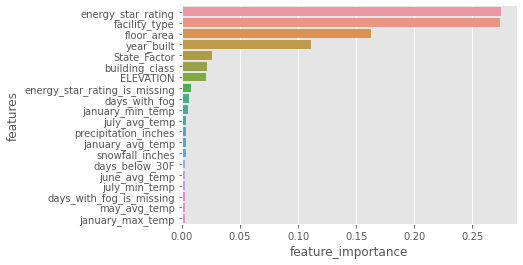

In [84]:
plot_features(X_train.columns, ideal_model.feature_importances_)

As per the above graph the key features to predict Site energy usage intensity is 
* Energy Star Rating
* Facility Type
* Floor Area
* Year built
* State Factor 
* Building Class
* Elevation

In [85]:
sum(ideal_model.feature_importances_)

1.0000000000000004

# Light Weight Model for deployment

In [89]:
key_features = ["energy_star_rating","facility_type","floor_area","year_built","State_Factor","building_class","ELEVATION"]

In [96]:
df_train_enc = preprocess_data(df_train)

In [97]:
df_train_enc

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,State_Factor_is_missing,building_class_is_missing,facility_type_is_missing,year_built_is_missing,energy_star_rating_is_missing,direction_max_wind_speed_is_missing,direction_peak_wind_speed_is_missing,max_wind_speed_is_missing,days_with_fog_is_missing
0,1,1,1,14,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,248.682615,0,False,False,False,False,False,False,False,False,True
1,1,1,1,56,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,26.500150,1,False,False,False,False,False,False,True,False,False
2,1,1,1,49,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,24.693619,2,False,False,False,False,False,False,True,False,False
3,1,1,1,7,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,48.406926,3,False,False,False,False,False,False,True,False,False
4,1,1,1,57,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,104.0,3.899395,4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,3,1,33,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,1.0,1.0,1.0,104.0,132.918411,75752,False,False,False,False,False,True,True,True,True
75753,6,3,2,2,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,1.0,1.0,1.0,104.0

In [98]:
# Split data into X & y
X_train, y_train = df_train_enc[key_features], df_train_enc.site_eui

In [99]:
%%time
# Most ideal hyperparameters
deploy_model = RandomForestRegressor(n_estimators=60,
                                    min_samples_leaf=7,
                                    min_samples_split=4,
                                    max_features='auto',
                                    max_depth=None,
                                    n_jobs=-1,
                                    max_samples=None)
deploy_model.fit(X_train, y_train)

Wall time: 1.56 s


RandomForestRegressor(min_samples_leaf=7, min_samples_split=4, n_estimators=60,
                      n_jobs=-1)

In [101]:
# Create function to evaluate our model
def show_scores_new(model):
    train_preds = model.predict(X_train)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Training RMSE": rmse(y_train, train_preds),
              "Training R^2": model.score(X_train, y_train)}
    return scores

In [102]:
show_scores_new(deploy_model)

{'Training MAE': 15.905363016667398,
 'Training RMSE': 33.84601246403199,
 'Training R^2': 0.6624420536927667}

# Save the revised model

In [103]:
with open('rf_site_deploy.joblib', 'wb') as f:
    joblib.dump(deploy_model, f, compress=1)

# Testing the model to deploy

In [114]:
with open('rf_site_deploy.joblib', 'rb') as f:
        rf = joblib.load(f)

In [115]:
X_train.iloc[[0]]

,energy_star_rating,facility_type,floor_area,year_built,State_Factor,building_class,ELEVATION
0,11.0,14,61242.0,1942.0,1,1,2.4


In [116]:
data = np.array([11.0,14,61242.0,1942.0,1,1,2.4]).reshape(1,-1)

In [117]:
result = rf.predict(data)
result

array([267.94407321])

In [118]:
y_train.iloc[[0]]

0    248.682615
Name: site_eui, dtype: float64

Our Prediction 267 is much closer to the training output of 248. We will now deploy this code for Prediction